In [55]:
! pip install prophet optuna mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [56]:
!mlflow ui

[2024-05-31 18:08:35 +0000] [8179] [INFO] Starting gunicorn 22.0.0
[2024-05-31 18:08:35 +0000] [8179] [INFO] Listening at: http://127.0.0.1:5000 (8179)
[2024-05-31 18:08:35 +0000] [8179] [INFO] Using worker: sync
[2024-05-31 18:08:35 +0000] [8180] [INFO] Booting worker with pid: 8180
[2024-05-31 18:08:35 +0000] [8181] [INFO] Booting worker with pid: 8181
[2024-05-31 18:08:35 +0000] [8182] [INFO] Booting worker with pid: 8182
[2024-05-31 18:08:35 +0000] [8183] [INFO] Booting worker with pid: 8183
[2024-05-31 18:11:00 +0000] [8179] [INFO] Handling signal: int
[2024-05-31 18:11:00 +0000] [8183] [INFO] Worker exiting (pid: 8183)
[2024-05-31 18:11:00 +0000] [8181] [INFO] Worker exiting (pid: 8181)
[2024-05-31 18:11:00 +0000] [8180] [INFO] Worker exiting (pid: 8180)
[2024-05-31 18:11:00 +0000] [8182] [INFO] Worker exiting (pid: 8182)

Aborted!
[2024-05-31 18:11:01 +0000] [8179] [INFO] Shutting down: Master


## Importing Libraries


In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
from prophet import Prophet
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt


c:\Users\hp\Desktop\Seita\ml_ops_assignment\venv-3_9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Data Import and Exploration

In [2]:
url = 'https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/energy/SF_hospital_load.csv'
data = pd.read_csv(url, index_col=[0], parse_dates=[0])

In [14]:
data.head()


,y
ds,
2015-01-01 01:00:00,778.007969
2015-01-01 02:00:00,776.241750
2015-01-01 03:00:00,779.357338
2015-01-01 04:00:00,778.737196
2015-01-01 05:00:00,787.835835


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 01:00:00 to 2016-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


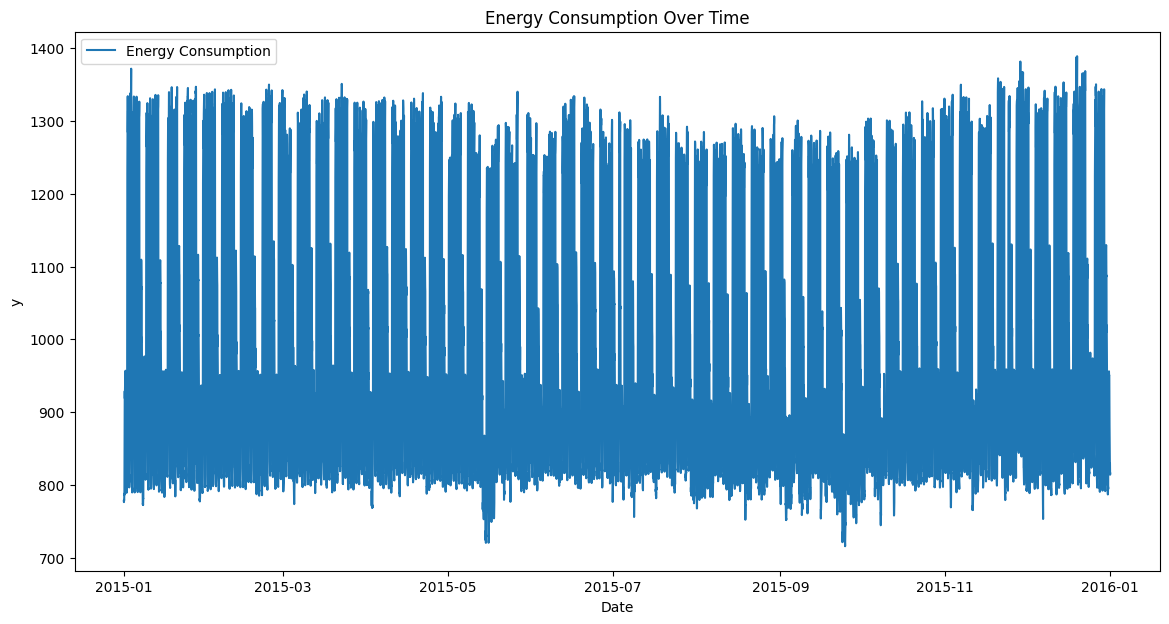

In [12]:
def plot_energy_consumption(df):
    # Plot the energy consumption over time
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['y'], label='Energy Consumption')
    plt.xlabel('Date')
    plt.ylabel('y')
    plt.title('Energy Consumption Over Time')
    plt.legend()
    plt.show()

plot_energy_consumption(data)

## Using MLflow for experiment tracking

In [3]:
def log_mlflow_run(run_name, model, X_train, y_train, X_test, y_test):
    with mlflow.start_run(run_name=run_name):
        # Log parameters
        mlflow.log_params({
            "model_name": type(model).__name__,
            "dataset": "energy_consumption",
        })

        # Fit the model
        model.fit(X_train, y_train)

        # Predict on test set
        y_pred = model.predict(X_test)

        # Log metrics
        mse = mean_squared_error(y_test, y_pred)
        mlflow.log_metric("mse", mse)

        # Log model
        mlflow.sklearn.log_model(model, "model")

        # Print results
        print(f"Model: {type(model).__name__}")
        print(f"Mean Squared Error (MSE): {mse}")

        # End MLflow run
        mlflow.end_run()

## Prophet Model Implementation



In [4]:
df = data.copy()

# Reset the index to make 'datetime' a column again
df.reset_index(inplace=True)


In [5]:
#Choosing Date to split Data 2 Months before last date

time_split = '2015-10-27'

In [6]:
#Splitting Data into train and val

train = df[df['ds'] < time_split]
val = df[df['ds'] >= time_split]

In [30]:
train.head()

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338
3,2015-01-01 04:00:00,778.737196
4,2015-01-01 05:00:00,787.835835


In [31]:
val.head()        

,ds,y
7175,2015-10-27 00:00:00,820.341131
7176,2015-10-27 01:00:00,818.556432
7177,2015-10-27 02:00:00,811.742936
7178,2015-10-27 03:00:00,818.953835
7179,2015-10-27 04:00:00,909.224690


## Training the Prophet Model

In [7]:
# Initialize the Prophet model
model = Prophet()

# Fit the model on the training dataset
model.fit(train[['ds', 'y']])

# Create a DataFrame for future predictions (5 days into the future)
future = model.make_future_dataframe(periods=5*24, freq='H')  # 5 days * 24 hours

# Make predictions
forecast = model.predict(future)

# Display the forecast
print("\nForecasted data:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

19:34:55 - cmdstanpy - INFO - Chain [1] start processing
19:35:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\hp\Desktop\Seita\ml_ops_assignment\venv-3_9\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(



Forecasted data:
                      ds         yhat  yhat_lower   yhat_upper
7290 2015-10-31 19:00:00  1024.272284  918.572306  1138.131296
7291 2015-10-31 20:00:00   950.502057  847.165031  1062.796941
7292 2015-10-31 21:00:00   896.239986  785.315384  1008.336967
7293 2015-10-31 22:00:00   865.739085  764.864146   973.382213
7294 2015-10-31 23:00:00   853.658691  745.279556   950.809207


## Compare Predictions with Validation Data

Mean Absolute Error (MAE): 67.02
Mean Absolute Percentage Error (MAPE): 6.76%
R-squared (R²): 0.82


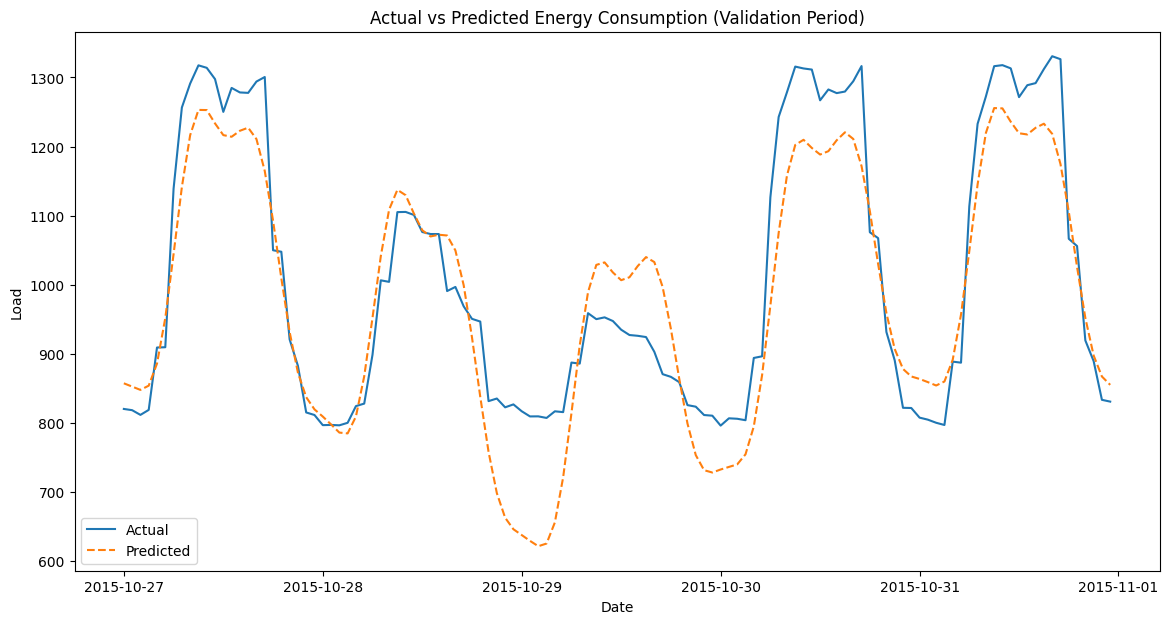

In [ ]:
# Filter the forecast to only include the validation period
forecast_val = forecast[forecast['ds'] >= time_split]

# Merge the validation data with the forecasted data
comparison = val[['ds', 'y']].merge(forecast_val[['ds', 'yhat']], on='ds')

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Calculate the Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(comparison['y'], comparison['yhat'])
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')

# Calculate the R-squared (R²) score
r2 = r2_score(comparison['y'], comparison['yhat'])
print(f'R-squared (R²): {r2:.2f}')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(comparison['ds'], comparison['y'], label='Actual')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Actual vs Predicted Energy Consumption (Validation Period)')
plt.legend()
plt.show()

## Saving Prophet Results

In [8]:
model_results={}

model_results['Prophet']={'MAE': 67.02,
                    'MAPE': 6.76,
                    'R²': 0.82}

##  XGBoost Model Implementation

In [9]:
df = data.copy()


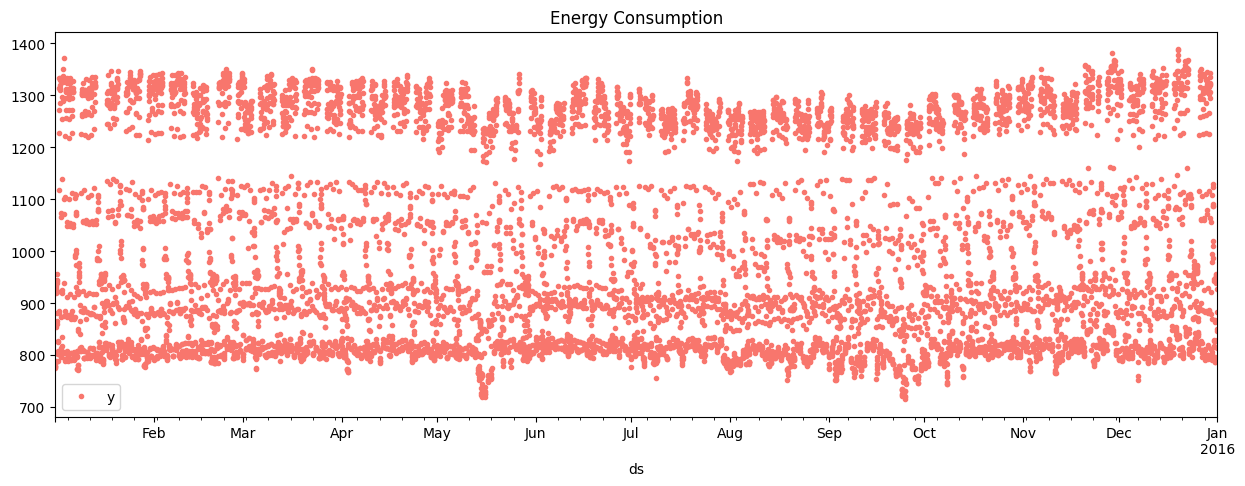

In [10]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='Energy Consumption')

## Train/Test Split

2 months val window

In [11]:
split_date = time_split

train = df.loc[df.index <= split_date].copy()
val = df.loc[df.index > split_date].copy()

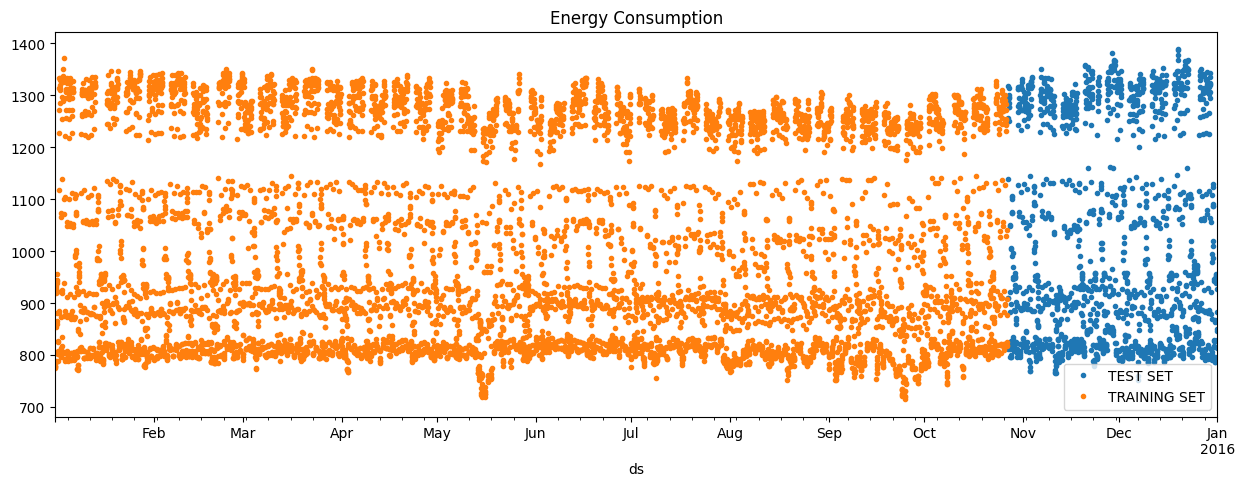

In [43]:
_ = val \
    .rename(columns={'y': 'TEST SET'}) \
    .join(train.rename(columns={'y': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Energy Consumption', style='.')

# Creating Additional Timeseries Features:

We create additional time series features to capture temporal patterns and improve the model's performance.


In [12]:
def create_features(df, label=None) :
    """
    Creates time series features from datetime index.

    Parameters:
    df (pd.DataFrame): The input dataframe with datetime index.
    label (str): The name of the target variable column (optional).

    Returns:
    X (pd.DataFrame): DataFrame containing the time series features.
    y (pd.Series): Series containing the target variable if label is provided.
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

## Train Test Split with New Feature Creation

In [13]:
X_train, y_train = create_features(train, label='y')
X_test, y_test = create_features(val, label='y')

In [47]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
ds,,,,,,,,
2015-01-01 01:00:00,1,3,1,1,2015,1,1,1
2015-01-01 02:00:00,2,3,1,1,2015,1,1,1
2015-01-01 03:00:00,3,3,1,1,2015,1,1,1
2015-01-01 04:00:00,4,3,1,1,2015,1,1,1
2015-01-01 05:00:00,5,3,1,1,2015,1,1,1
...,...,...,...,...,...,...,...,...
2015-10-26 20:00:00,20,0,4,10,2015,299,26,44
2015-10-26 21:00:00,21,0,4,10,2015,299,26,44
2015-10-26 22:00:00,22,0,4,10,2015,299,26,44


## Creating XGBoost Model

In [14]:
model = xgb.XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

c:\Users\hp\Desktop\Seita\ml_ops_assignment\venv-3_9\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Visualizing Feature Importance

To understand which features are most influential in our XGBoost model, we can plot the feature importance. This helps us interpret the model and identify the key factors driving energy consumption predictions.


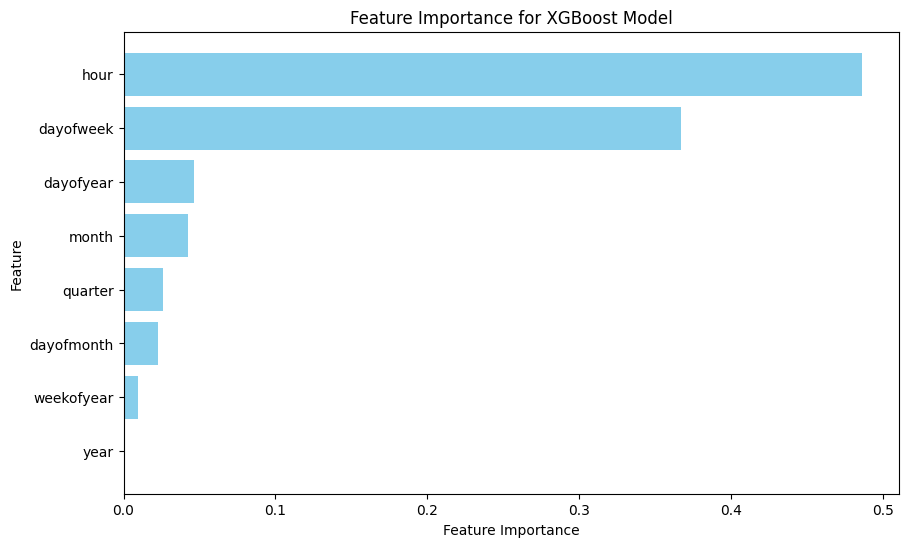

In [15]:
def plot_feature_importance(model, feature_names):
    """
    Plots the feature importance for a given model.

    Parameters:
    model (XGBRegressor): Trained XGBoost model
    feature_names (list of str): List of feature names

    Returns:
    None: This function plots the feature importance
    """
    # Extract feature importances from the model
    importance = model.feature_importances_

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance for XGBoost Model')
    plt.gca().invert_yaxis()  # Invert y axis to show the highest importance at the top
    plt.show()

# Example usage
feature_names = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']

# Assuming you have already trained your xgb_model as shown in previous steps
plot_feature_importance(model, feature_names)

## Forecast on Test Set


In [18]:
val = val['hour',]

,y,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y_hat
ds,,,,,,,,,,,
2015-10-27 01:00:00,818.556432,2015-10-27 01:00:00,1,1,4,10,2015,300,27,44,811.147888
2015-10-27 02:00:00,811.742936,2015-10-27 02:00:00,2,1,4,10,2015,300,27,44,811.147888
2015-10-27 03:00:00,818.953835,2015-10-27 03:00:00,3,1,4,10,2015,300,27,44,811.147888
2015-10-27 04:00:00,909.224690,2015-10-27 04:00:00,4,1,4,10,2015,300,27,44,894.992371
2015-10-27 05:00:00,909.633411,2015-10-27 05:00:00,5,1,4,10,2015,300,27,44,894.992371
...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 20:00:00,845.563081,2015-12-31 20:00:00,20,3,4,12,2015,365,31,53,821.768311
2015-12-31 21:00:00,827.530521,2015-12-31 21:00:00,21,3,4,12,2015,365,31,53,817.172607
2015-12-31 22:00:00,829.256300,2015-12-31 22:00:00,22,3,4,12,2015,365,31,53,809.522583


In [16]:
val['y_hat'] = model.predict(X_test)
df_all = pd.concat([val, train], sort=False)

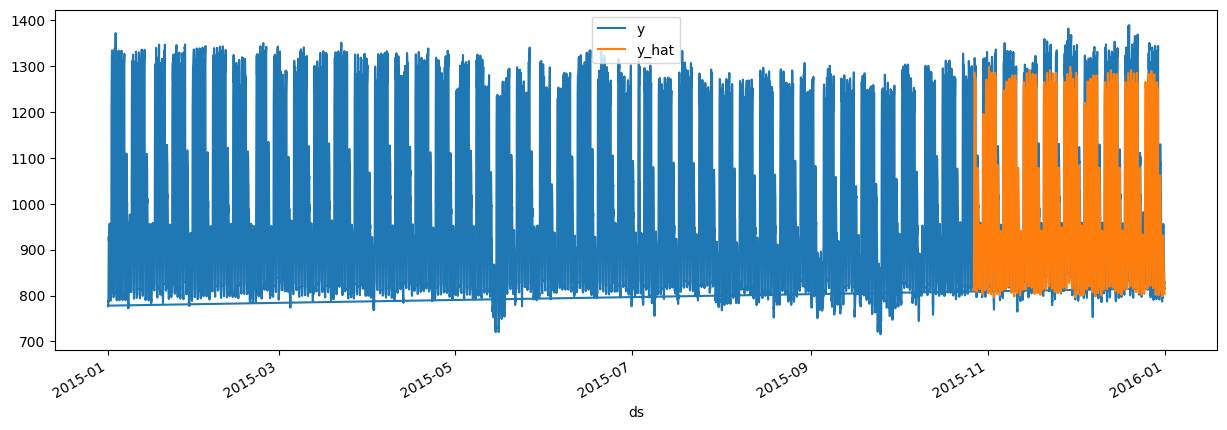

In [17]:
_ = df_all[['y','y_hat']].plot(figsize=(15, 5))


## Error Metrics On Test Set


Mean Absolute Error (MAE): 53.97
Mean Squared Error (MSE): 7641.77
Root Mean Squared Error (RMSE): 87.42
Mean Absolute Percentage Error (MAPE): 5.20%
R-squared (R²): 0.82


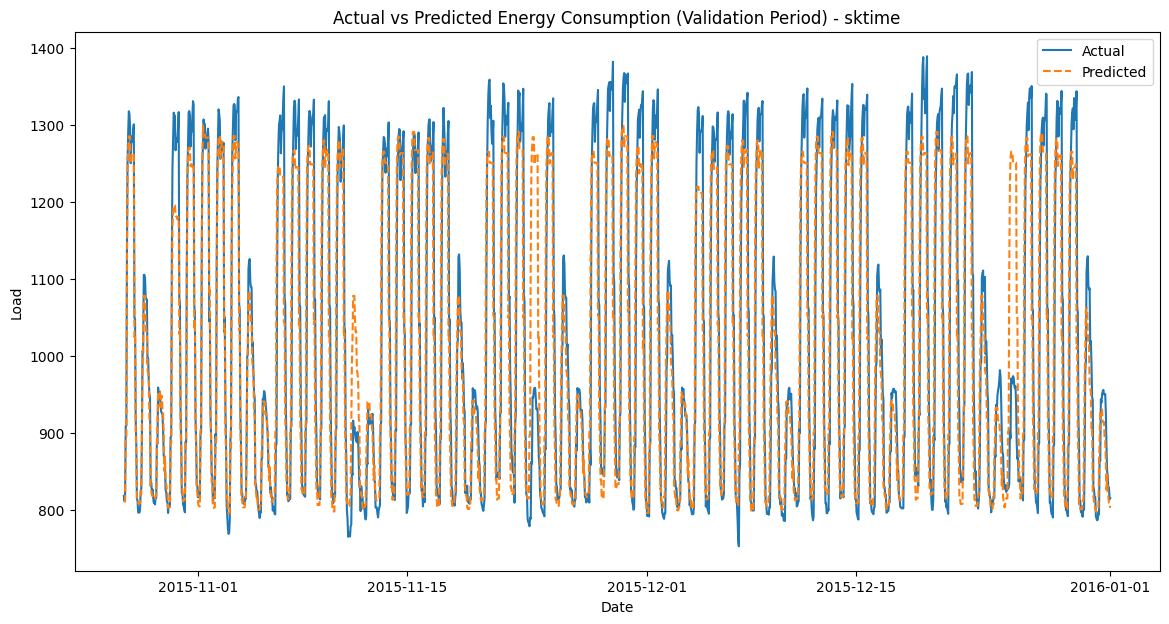

In [54]:
# Calculate evaluation metrics
y_val = val['y']
y_pred = val['y_hat']
mae = mean_absolute_error(y_true=val['y'],
                          y_pred=val['y_hat'])

mse = mean_squared_error(y_true=val['y'],
                          y_pred=val['y_hat'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true=val['y'],
                          y_pred=val['y_hat'])
r2 = r2_score(y_true=val['y'],
                          y_pred=val['y_hat'])

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')
print(f'R-squared (R²): {r2:.2f}')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_val.index, y_val, label='Actual')
plt.plot(y_val.index, y_pred, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Actual vs Predicted Energy Consumption (Validation Period) - sktime')
plt.legend()
plt.show()

In [26]:
def xgb_model_results(train,val,feature_names):

        X_train, y_train = create_features(train, label='y')
        X_test, y_test = create_features(val, label='y')

        X_train = X_train[feature_names]
        X_test = X_test[feature_names]
        model = xgb.XGBRegressor(n_estimators=1000)
        model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                early_stopping_rounds=50,
        verbose=False)
        val['y_hat'] = model.predict(X_test)
        df_all = pd.concat([val, train], sort=False)

        # Calculate evaluation metrics
        y_val = val['y']
        y_pred = val['y_hat']
        
        mae = mean_absolute_error(y_true=val['y'],
                                y_pred=val['y_hat'])

        mse = mean_squared_error(y_true=val['y'],
                                y_pred=val['y_hat'])
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_true=val['y'],
                                y_pred=val['y_hat'])
        r2 = r2_score(y_true=val['y'],
                                y_pred=val['y_hat'])

        print(f'Mean Absolute Error (MAE): {mae:.2f}')
        print(f'Mean Squared Error (MSE): {mse:.2f}')
        print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
        print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')
        print(f'R-squared (R²): {r2:.2f}')

        
        # Plot the actual vs predicted values
        plt.figure(figsize=(14, 7))
        plt.plot(y_val.index, y_val, label='Actual')
        plt.plot(y_val.index, y_pred, label='Predicted', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Load')
        plt.title('Actual vs Predicted Energy Consumption (Validation Period) - sktime')
        plt.legend()
        plt.show()

c:\Users\hp\Desktop\Seita\ml_ops_assignment\venv-3_9\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean Absolute Error (MAE): 53.17
Mean Squared Error (MSE): 7522.14
Root Mean Squared Error (RMSE): 86.73
Mean Absolute Percentage Error (MAPE): 5.14%
R-squared (R²): 0.82


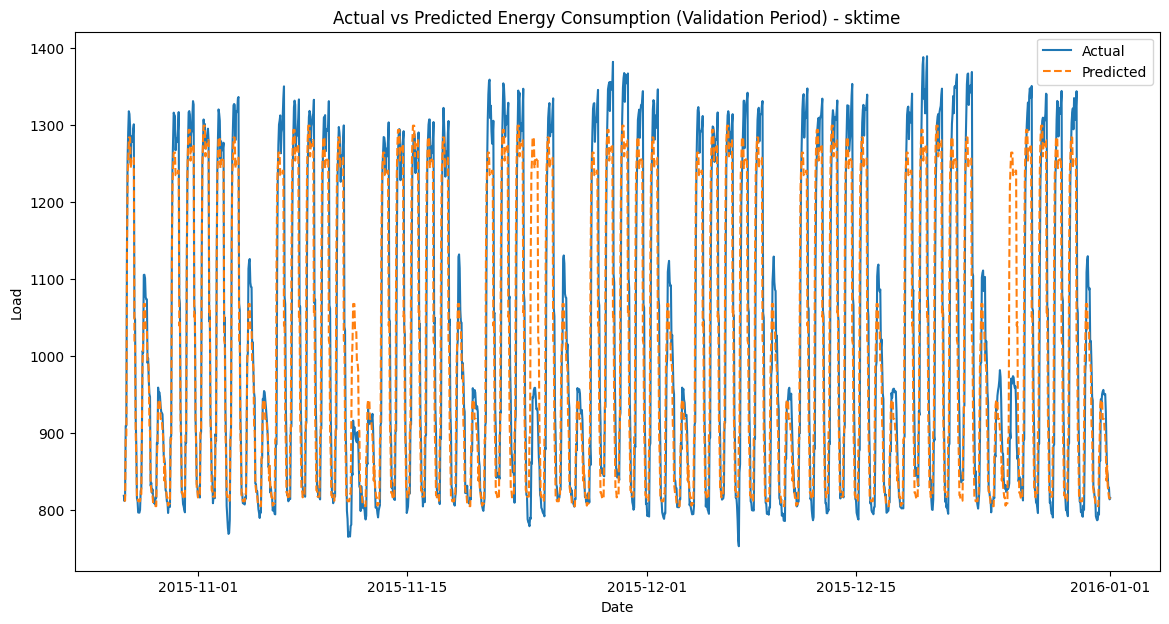

In [27]:
xgb_model_results(train,val,feature_names=['hour', 'dayofweek', 'dayofyear'])

c:\Users\hp\Desktop\Seita\ml_ops_assignment\venv-3_9\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean Absolute Error (MAE): 48.71
Mean Squared Error (MSE): 5702.16
Root Mean Squared Error (RMSE): 75.51
Mean Absolute Percentage Error (MAPE): 4.70%
R-squared (R²): 0.86


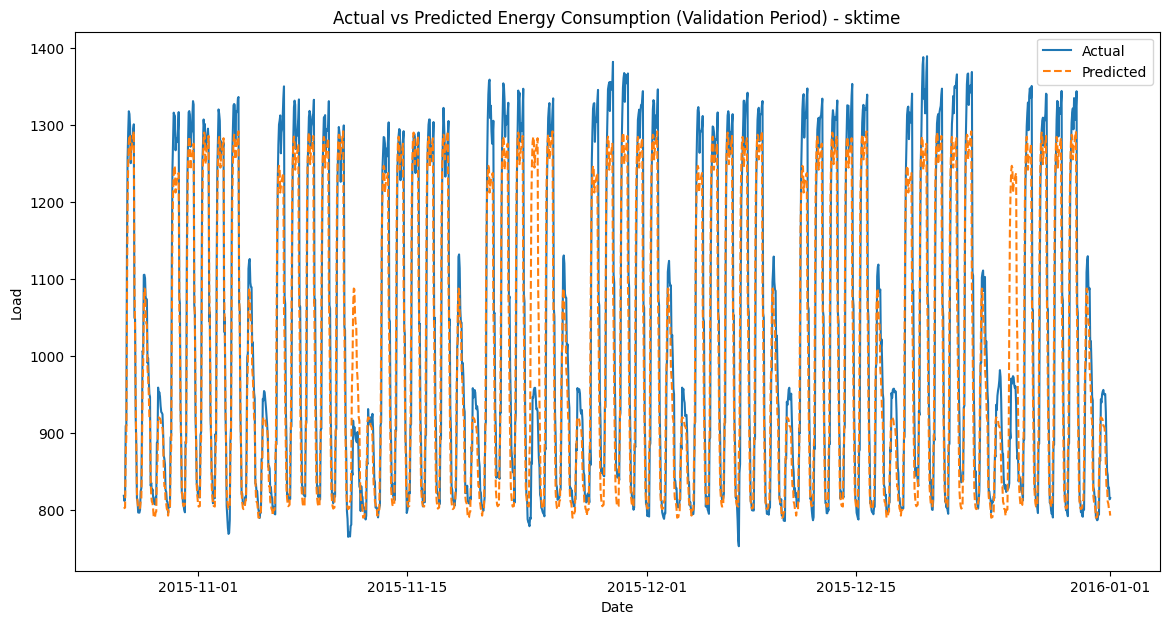

In [28]:
xgb_model_results(train,val,feature_names=['hour', 'dayofweek'])

c:\Users\hp\Desktop\Seita\ml_ops_assignment\venv-3_9\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean Absolute Error (MAE): 97.08
Mean Squared Error (MSE): 15746.26
Root Mean Squared Error (RMSE): 125.48
Mean Absolute Percentage Error (MAPE): 9.17%
R-squared (R²): 0.62


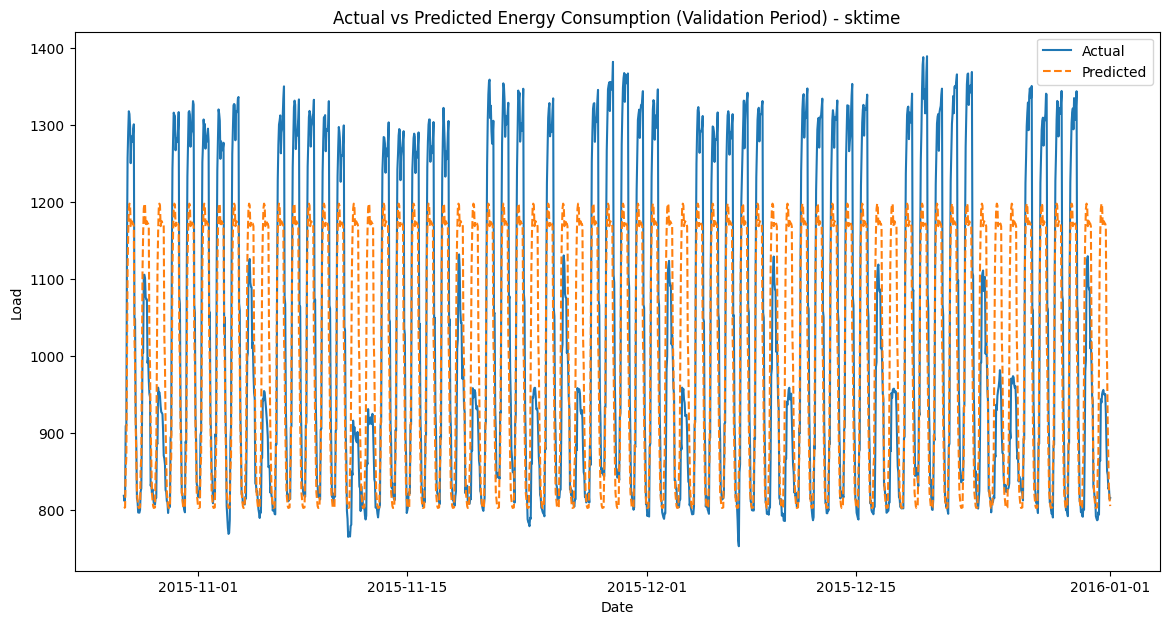

In [29]:
xgb_model_results(train,val,feature_names=['hour'])

## Optimization with Optuna

In [ ]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBRegressor
import optuna

[I 2024-05-30 02:05:59,363] A new study created in memory with name: no-name-eb89ddcf-534a-4719-a385-d7d3f1bfe575
<ipython-input-104-2a46bc37d285>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
<ipython-input-104-2a46bc37d285>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
<ipython-input-104-2a46bc37d285>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

Best Parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.16350418119033, 'subsample': 0.7783412676140228, 'colsample_bytree': 0.9392041203732997, 'gamma': 0.20764138196045878, 'min_child_weight': 10, 'random_state': 42, 'tree_method': 'auto'}
Mean Absolute Error (MAE): 44.99
Mean Absolute Percentage Error (MAPE): 4.25%
R-squared (R²): 0.89


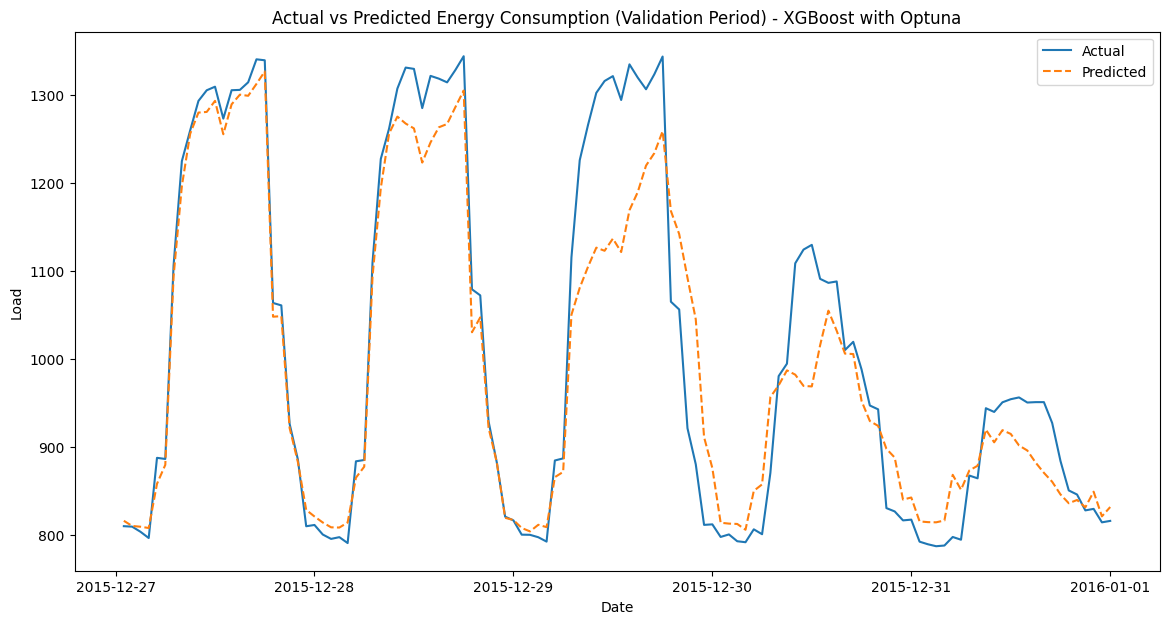

In [ ]:
# Define objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'tree_method': 'auto'
    }

    model = XGBRegressor(**params)
    forecaster = make_reduction(model, window_length=24, strategy="recursive")
    forecaster.fit(y_train)
    fh = ForecastingHorizon(y_val.index, is_relative=False)
    y_pred = forecaster.predict(fh)

    return mean_squared_error(y_val, y_pred)

# Optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
best_params['random_state'] = 42
best_params['tree_method'] = 'auto'

# Train the final model with the best hyperparameters
final_model = XGBRegressor(**best_params)
forecaster = make_reduction(final_model, window_length=24, strategy="recursive")
forecaster.fit(y_train)

# Make predictions on the validation set
y_pred = forecaster.predict(fh)

# Calculate evaluation metrics
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')
print(f'R-squared (R²): {r2:.2f}')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_val.index, y_val, label='Actual')
plt.plot(y_val.index, y_pred, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Actual vs Predicted Energy Consumption (Validation Period) - XGBoost with Optuna')
plt.legend()
plt.show()

In [ ]:
import pickle


# Save the trained model using pickle
with open('xgboost_energy_model.pkl', 'wb') as f:
    pickle.dump(forecaster, f)

## Forcasting with Sktime

In [ ]:
! pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.1/130.1 kB 13.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.ensemble import RandomForestRegressor

In [ ]:
url = 'https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/energy/SF_hospital_load.csv'
df = pd.read_csv(url)

In [ ]:
df

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338
3,2015-01-01 04:00:00,778.737196
4,2015-01-01 05:00:00,787.835835
...,...,...
8755,2015-12-31 20:00:00,845.563081
8756,2015-12-31 21:00:00,827.530521
8757,2015-12-31 22:00:00,829.256300
8758,2015-12-31 23:00:00,813.937205


In [ ]:
df['ds'] = pd.to_datetime(df['ds'])

# Set 'datetime' as the index
df.set_index('ds', inplace=True)
y = df['y']

# Split the data into training and validation sets
y_train, y_val = temporal_train_test_split(y, test_size=5*24)
fh = ForecastingHorizon(y_val.index, is_relative=False)

## Train the sktime Model

In [ ]:
# Initialize the sktime model with a regressor
regressor = RandomForestRegressor(n_estimators=100)
forecaster = make_reduction(regressor, window_length=24, strategy="recursive")

# Fit the model on the training data
forecaster.fit(y_train)

# Make predictions on the validation set
y_pred = forecaster.predict(fh)

# Calculate evaluation metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')
print(f'R-squared (R²): {r2:.2f}')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_val.index, y_val, label='Actual')
plt.plot(y_val.index, y_pred, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Actual vs Predicted Energy Consumption (Validation Period) - sktime')
plt.legend()
plt.show()

Mean Absolute Error (MAE): 184.66
Mean Squared Error (MSE): 57854.47
Root Mean Squared Error (RMSE): 240.53
Mean Absolute Percentage Error (MAPE): 16.96%
R-squared (R²): -0.41


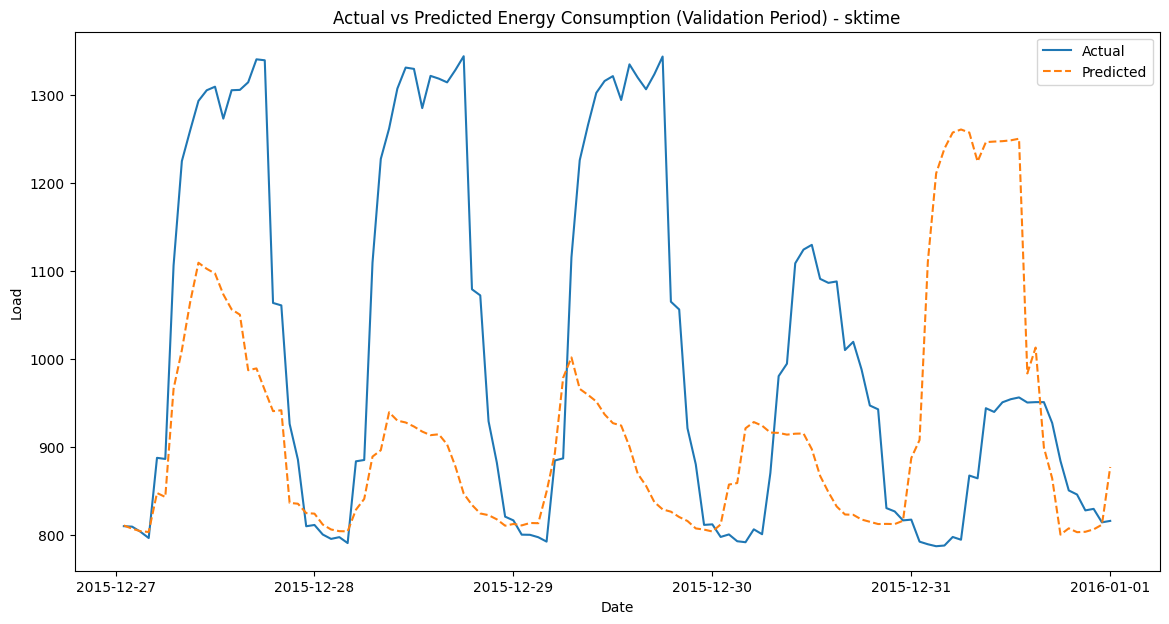

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Load the dataset
url = 'https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/energy/SF_hospital_load.csv'
df = pd.read_csv(url)

# Convert the 'datetime' column to datetime type and set as index
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# Define split date
split_date = '2015-10-27'

# Split the data into training and validation sets
train = df.loc[df.index <= split_date].copy()
val = df.loc[df.index > split_date].copy()

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
           'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

# Create features
X, y = create_features(df, label='y')

# Split the data into training and validation sets
y_train, y_val = temporal_train_test_split(y, test_size=5*24)
fh = ForecastingHorizon(y_val.index, is_relative=False)

# Initialize the sktime model with a regressor
regressor = RandomForestRegressor(n_estimators=100)
forecaster = make_reduction(regressor, window_length=24, strategy="recursive")

# Fit the model on the training data
forecaster.fit(y_train)

# Make predictions on the validation set
y_pred = forecaster.predict(fh)

# Calculate evaluation metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')
print(f'R-squared (R²): {r2:.2f}')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_val.index, y_val, label='Actual')
plt.plot(y_val.index, y_pred, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Actual vs Predicted Energy Consumption (Validation Period) - sktime')
plt.legend()
plt.show()

In [ ]:
with open('/content/xgboost_energy_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

In [ ]:
model

RecursiveTabularRegressionForecaster(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9392041203732997, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.20764138196045878,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.16350418119033,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...),
                                     window_length=24)